# **Importing Required Libraries**

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import os
from torchvision import models
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Downloading and extracting data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/My\ Drive/visualsimilarity.zip

Archive:  gdrive/My Drive/visualsimilarity.zip
replace bottoms_resized_png/13079565VVD.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **ImageData class which preprocesses the images to be used for our pretrained model.**

In [ ]:
class ImageData():

  def __init__(self, fpath):

    inputDim = (224, 224)
    self.fname = []
    self.files = []
    self.composed = transforms.Compose([transforms.Resize(inputDim)])
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    self.toTensor = transforms.ToTensor()

    for imagename in os.listdir(fpath):
      img = Image.open(os.path.join(fpath, imagename)).convert("RGB") #3 channeled imaged
      transformed_img = self.composed(img)
      transformed_img_tensor = self.toTensor(transformed_img).to(device)
      normalized_img = self.normalize(transformed_img_tensor)
      self.files.append(normalized_img)
      self.fname.append(imagename)
      transformed_img.close()
      img.close()

  def __len__(self):
    return len(self.files)
  
  def __getitem__(self, index):
    return (self.fname[index], self.files[index])



In [ ]:
fpath = "/content/bottoms_resized_png"
dataset = ImageData(fpath)

In [ ]:
map_product = {}
for i,imagename in enumerate(os.listdir(fpath)):
  map_product[imagename] = i

In [ ]:
dataset[0][0]

'13530476UDD.png'

In [ ]:
len(dataset)

1050

# **Making Our Model**

In [ ]:
class Tensor2Vec():

  def __init__(self, dataset):

    self.model = models.resnet18(weights= "ResNet18_Weights.DEFAULT")

    #number of features
    self.number_of_features = 512

    #avg pool layer
    self.layer = self.model._modules.get('avgpool')
    #feature vector
    self.features= []

    #dataset
    self.fname, self.files = zip(*dataset)

    #similarit
    self.similar = None

    #top-10 recommendation
    self.recommend_files = {}

    self.recommend_values = {}


    self.k_close = 10

  def extract_features(self, given_image):

    my_embeddings = torch.zeros(1, self.number_of_features , 1, 1)

    def copy_data(self, input, output):
      my_embeddings.copy_(output.data)

    forward = self.layer.register_forward_hook(copy_data)

    self.model(given_image.unsqueeze(0))

    forward.remove()

    return my_embeddings.squeeze(0).numpy().reshape(1,-1)

  
  def all_features(self):
    feat = []
    for fdata in self.files:

      feat.append(self.extract_features(fdata))
    self.features = np.vstack(feat)

  def get_similarity(self):
    closest = []
    all_similarity = cosine_similarity(self.features)
    self.similar = pd.DataFrame(all_similarity , columns = self.fname, index = self.fname)
    for filename in self.fname:
      closest_name = self.similar[filename].sort_values(ascending = False)[1:self.k_close+1].index
      closest_value = self.similar[filename].sort_values(ascending = False)[1:self.k_close+1].values
      self.recommend_files[filename] = list(closest_name)
      self.recommend_values[filename] = list(closest_value)
  
  def execute(self):
    self.all_features()
    self.get_similarity()

  def __getitem__(self, fname):
    if fname in self.recommend_files:
      return list(zip(self.recommend_files[fname], self.recommend_values[fname]))
    else:
      return None


  

Create Vectors Object

In [ ]:
vectors = Tensor2Vec(dataset)

Execute the functions to get ourselves a similarity matrix


In [ ]:
vectors.execute()


In [ ]:
test_file_name = dataset[0][0]

In [ ]:
print(vectors[test_file_name])

[('13585481HTD.png', 0.9989475), ('13587131QOR.png', 0.99884886), ('13586788IQR.png', 0.9987491), ('13530476UDR.png', 0.99873984), ('13579130ARR.png', 0.9987307), ('13572088BER.png', 0.99871874), ('13585975INR.png', 0.99868846), ('13586788IQD.png', 0.99867666), ('13589071EJD.png', 0.9986669), ('13586573NJD.png', 0.99863875)]


# **Storing Results of our model**

In [ ]:
pd.DataFrame(vectors.recommend_files).to_pickle("store_recommendations_names.pkl")
pd.DataFrame(vectors.recommend_values).to_pickle("store_recommendations_values.pkl")

In [ ]:
saved_names = open("store_recommendations_names.pkl", "rb")
saved_values = open("store_recommendations_values.pkl", "rb")
load_names = pickle.load(saved_names)
load_values = pickle.load(saved_values)

In [ ]:
load_names.head(1)

,13530476UDD.png,13587410NOD.png,35468897QSR.png,13586416QDR.png,13585804KID.png,13586978VXR.png,13587442AMR.png,35469154OGD.png,35467798JQR.png,35466660NLR.png,...,35468998UGR.png,13588288WXR.png,13586451RPD.png,13587485NIR.png,13586941GBD.png,13512944AOR.png,13587353MAD.png,35468339TVR.png,35469318WHR.png,13585410SAR.png
0,13585481HTD.png,13587410NOR.png,35468897QSD.png,13586939KAR.png,13585804KIR.png,13586354JSR.png,13587442AMD.png,35469154OGR.png,35467798JQD.png,13636697LKR.png,...,13586146FCD.png,13584698RXR.png,13581097NPR.png,13589347MSD.png,13589140TBD.png,13585481HTD.png,13587353MAR.png,35468590GFD.png,13584294WPD.png,13585410SAD.png


In [ ]:
load_values.head(1)

,13530476UDD.png,13587410NOD.png,35468897QSR.png,13586416QDR.png,13585804KID.png,13586978VXR.png,13587442AMR.png,35469154OGD.png,35467798JQR.png,35466660NLR.png,...,35468998UGR.png,13588288WXR.png,13586451RPD.png,13587485NIR.png,13586941GBD.png,13512944AOR.png,13587353MAD.png,35468339TVR.png,35469318WHR.png,13585410SAR.png
0,0.998948,0.998921,0.998731,0.998755,0.998729,0.998765,0.999027,0.998727,0.998928,0.99862,...,0.998712,0.998743,0.998771,0.998701,0.998694,0.998685,0.999066,0.998906,0.99867,0.998904


# **Plotting our results**

In [ ]:
def plot(names, values , given_image_name):
    
    fig = plt.figure(figsize=(16,12))
    ax = None
    ax = fig.add_subplot(131)
    given_image = Image.open(os.path.join(fpath, given_image_name))
    ax.imshow(given_image)
    plt.title("Original Image\n"+given_image_name)
    ax.title.set_size(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    given_image.close()
    print("Similar Products: ")
    similar_names = names[given_image_name]
    similar_values = values[given_image_name]
    for i in range(0,10):
      ax = None
      ax = fig.add_subplot(2,8, i%5 + 4 + (i//5) * 8)
      ax.imshow(Image.open(os.path.join(fpath, similar_names[i])))
      plt.title(similar_names[i]+"\nvalues"+str(similar_values[i])+"\n")
      ax.title.set_size(7)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

    plt.show()

Similar Products: 


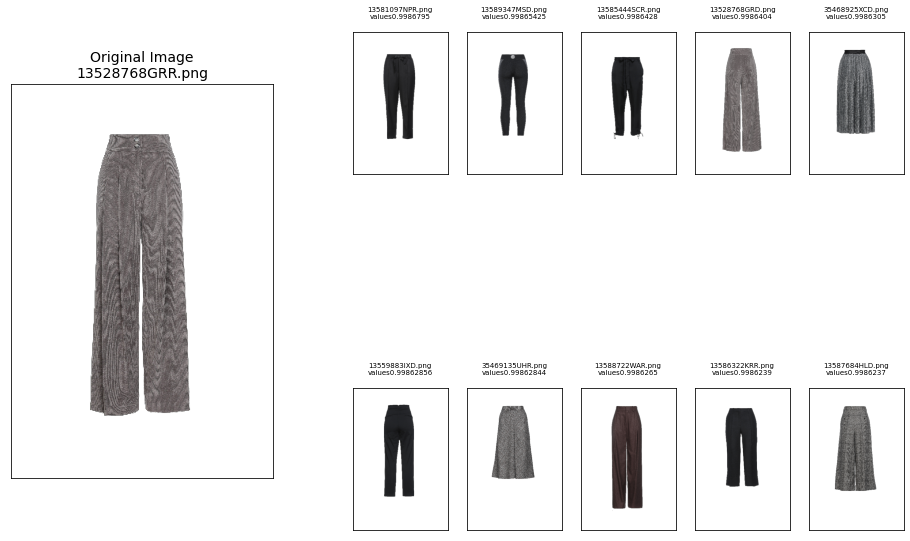

In [ ]:
plot(load_names, load_values , '13528768GRR.png')